Fitted parameters: λ=0.200, μ=0.275, σ=0.500
Bootstrap CIs:
  λ: [0.02141037 0.2       ]
  μ: [0.14210224 0.3       ]
  σ: [0.34584001 0.5       ]


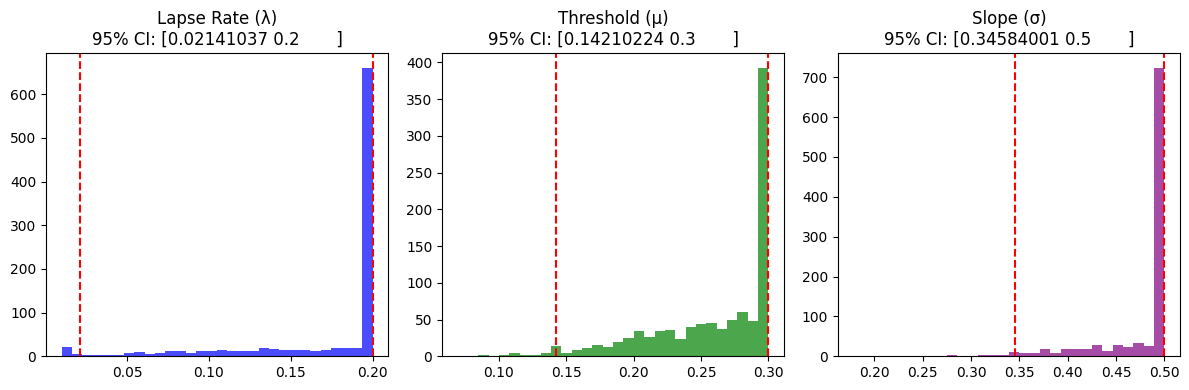

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.05, 0, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.5)]  # Reasonable bounds
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['delta_dur_adjusted'], data_grouped['chose_test'], data_grouped['response']),
        bounds=bounds
    )
    return result.x

# Generate synthetic dataset based on fitted parameters
def generate_synthetic_data(delta_dur, total_responses, params):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # p is the probability of choosing the test stimulus in terms of proportion of total responses
    simulated_chose_test = np.random.binomial(total_responses, p) # simulate the number of times the test stimulus was chosen 
    return simulated_chose_test

# Parametric bootstrapping
def parametric_bootstrap(data_grouped, fitted_params, n_bootstrap=1000):
    delta_dur = data_grouped['delta_dur_adjusted'].values
    total_responses = data_grouped['response'].values
    bootstrap_estimates = []

    for _ in range(n_bootstrap):
        # Generate synthetic responses
        synthetic_chose_test = generate_synthetic_data(delta_dur, total_responses, fitted_params)

        # Create a synthetic dataset
        synthetic_data = pd.DataFrame({
            'delta_dur_adjusted': delta_dur,
            'chose_test': synthetic_chose_test,
            'response': total_responses
        })

        # Fit the psychometric function to the synthetic data
        bootstrap_params = fit_psychometric_function(synthetic_data)
        bootstrap_estimates.append(bootstrap_params)

    return np.array(bootstrap_estimates)

# Load data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Prepare data (as before)
data['chose_test'] = (data['response'] == data['test_order']).astype(int)
grouped = data.groupby(['rise_dur', 'delta_dur_adjusted']).agg(
    chose_test=('chose_test', 'sum'),
    response=('response', 'count')
).reset_index()

# Fit psychometric function to real data
fitted_params = fit_psychometric_function(grouped)
print(f"Fitted parameters: λ={fitted_params[0]:.3f}, μ={fitted_params[1]:.3f}, σ={fitted_params[2]:.3f}")

# Perform parametric bootstrapping
n_bootstrap = 1000
bootstrap_estimates = parametric_bootstrap(grouped, fitted_params, n_bootstrap=n_bootstrap)


In [18]:
bootstrap_estimates

array([[0.2       , 0.2192645 , 0.5       ],
       [0.2       , 0.2492046 , 0.45972317],
       [0.2       , 0.20388554, 0.5       ],
       ...,
       [0.2       , 0.3       , 0.5       ],
       [0.19148968, 0.24590075, 0.5       ],
       [0.2       , 0.20399673, 0.5       ]])

In [ ]:

# Analyze bootstrap results
lambda_estimates, mu_estimates, sigma_estimates = bootstrap_estimates.T
lambda_ci = np.percentile(lambda_estimates, [2.5, 97.5])
mu_ci = np.percentile(mu_estimates, [2.5, 97.5])
sigma_ci = np.percentile(sigma_estimates, [2.5, 97.5])

print(f"Bootstrap CIs:\n  λ: {lambda_ci}\n  μ: {mu_ci}\n  σ: {sigma_ci}")

# Plot bootstrap distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(lambda_estimates, bins=30, color='blue', alpha=0.7)
plt.axvline(lambda_ci[0], color='red', linestyle='--')
plt.axvline(lambda_ci[1], color='red', linestyle='--')
plt.title(f"Lapse Rate (λ)\n95% CI: {lambda_ci}")

plt.subplot(1, 3, 2)
plt.hist(mu_estimates, bins=30, color='green', alpha=0.7)
plt.axvline(mu_ci[0], color='red', linestyle='--')
plt.axvline(mu_ci[1], color='red', linestyle='--')
plt.title(f"Threshold (μ)\n95% CI: {mu_ci}")

plt.subplot(1, 3, 3)
plt.hist(sigma_estimates, bins=30, color='purple', alpha=0.7)
plt.axvline(sigma_ci[0], color='red', linestyle='--')
plt.axvline(sigma_ci[1], color='red', linestyle='--')
plt.title(f"Slope (σ)\n95% CI: {sigma_ci}")

plt.tight_layout()
plt.show()


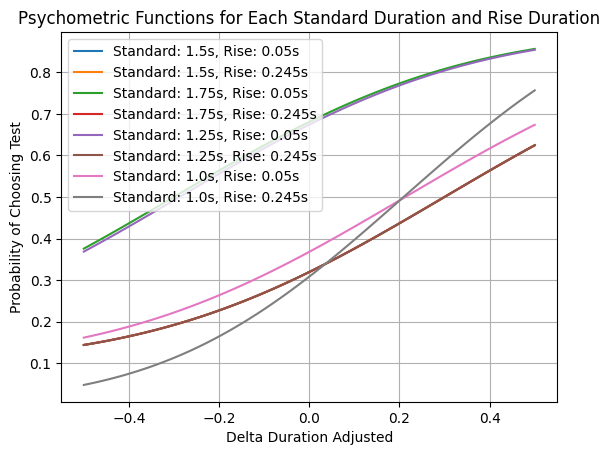

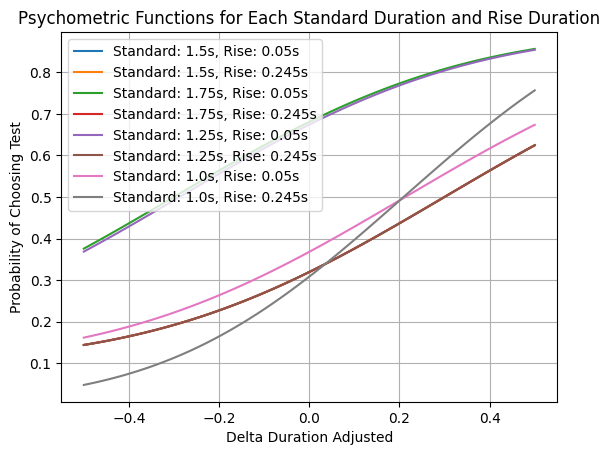

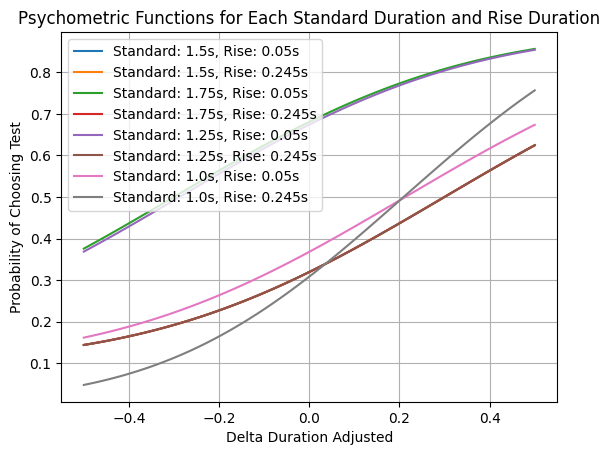

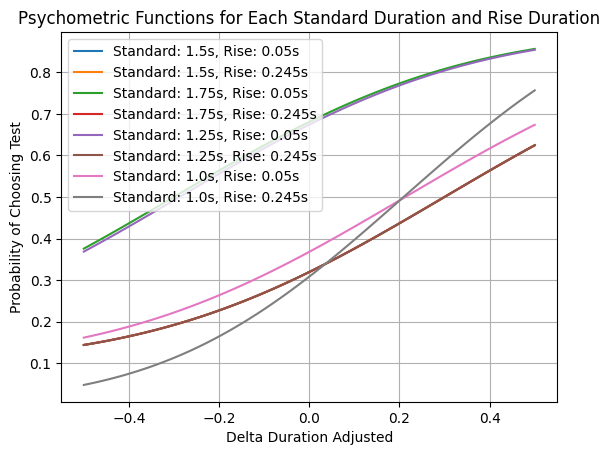

In [16]:

# Plot psychometric function with CIs
for standard_dur in unique_standard_durs:
    intensities = np.linspace(-0.5, 0.5, 100)

    for standard_dur in unique_standard_durs:
        for rise_dur in data['rise_dur'].unique():
            subset = data[(data['standard_dur'] == standard_dur) & (data['rise_dur'] == rise_dur)]
            grouped_subset = subset.groupby(['delta_dur_adjusted']).agg(
                chose_test=('chose_test', 'sum'),
                response=('response', 'count')
            ).reset_index()
            if not grouped_subset.empty:
                fitted_params_subset = fit_psychometric_function(grouped_subset)
                p_fit = psychometric_function(intensities, *fitted_params_subset)
                
                # Bootstrap CIs
                bootstrap_estimates_subset = parametric_bootstrap(grouped_subset, fitted_params_subset, n_bootstrap=1000)
                p_bootstrap = np.array([psychometric_function(intensities, *params) for params in bootstrap_estimates_subset])
                p_ci_lower = np.percentile(p_bootstrap, 2.5, axis=0)
                p_ci_upper = np.percentile(p_bootstrap, 97.5, axis=0)
                
                plt.plot(intensities, p_fit, label=f'Standard: {standard_dur}s, Rise: {rise_dur}s')
                #plt.fill_between(intensities, p_ci_lower, p_ci_upper, alpha=0.2)

    plt.xlabel('Delta Duration Adjusted')
    plt.ylabel('Probability of Choosing Test')
    plt.title('Psychometric Functions for Each Standard Duration and Rise Duration')
    plt.legend()
    plt.grid(True)
    plt.show()

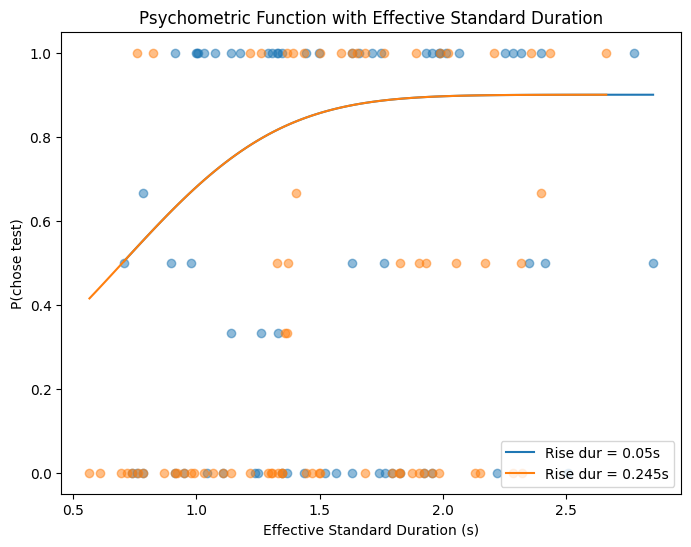

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, standard_duration, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(standard_duration, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.05, 0.5, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (0.3, 0.7), (0.01, 0.5)]  # Reasonable bounds for parameters
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['effective_standard'], data_grouped['chose_test'], data_grouped['response']),
        bounds=bounds
    )
    return result.x

# Load data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Add chose_test column
data = data.assign(chose_test=(data['response'] == data['test_order']).astype(int))

# Calculate effective standard duration for X-axis
data['effective_standard'] = data['delta_dur_adjusted'] + data['standard_dur']

# Group data by rise_dur and effective_standard
grouped = data.groupby(['rise_dur', 'effective_standard']).agg(
    chose_test=('chose_test', 'sum'),
    response=('response', 'count')
).reset_index()

# Plot psychometric functions for each rise_dur
plt.figure(figsize=(8, 6))
grouped_by_rise_dur = grouped.groupby('rise_dur')

for rise_dur, group in grouped_by_rise_dur:
    # Fit psychometric function
    result = fit_psychometric_function(group)
    lambda_, mu, sigma = result

    # Plot psychometric function
    intensities = np.linspace(group['effective_standard'].min(), group['effective_standard'].max(), 100)
    p_test = psychometric_function(intensities, lambda_, mu, sigma)
    plt.plot(intensities, p_test, label=f"Rise dur = {rise_dur}s")
    
    # Scatter data points
    plt.scatter(group['effective_standard'], group['chose_test'] / group['response'], alpha=0.5)

plt.xlabel('Effective Standard Duration (s)')
plt.ylabel('P(chose test)')
plt.title('Psychometric Function with Effective Standard Duration')
plt.legend()
plt.show()


In [ ]:
rise_05 = grouped[grouped['rise_dur'] == 0.050]
rise_0245 = grouped[grouped['rise_dur'] == 0.245]

plt.figure(figsize=(12, 8))

for i in data['standard_dur'].unique():
    X = data[data['standard_dur'] == i]
    X['chose_test'] = (X['response'] == X['test_order']).astype(int)

    grouped = X.groupby(['delta_dur_adjusted', 'rise_dur']).agg(
        total_responses=('response', 'count'),
        chose_test=('chose_test', 'sum')
    ).reset_index()

    grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

    for j in grouped['rise_dur'].unique():
        if j == 0.050:
            lineStyle = '--'
        else:
            lineStyle = '-'

        Y = grouped[grouped['rise_dur'] == j]
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(Y)
        print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

        x_data = Y['delta_dur_adjusted']
        y_data = Y['p_choose_test']
        bin_edges = np.histogram_bin_edges(x_data, bins=5)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        y_data_binned = np.zeros(len(bin_centers))
        for k in range(len(bin_centers)):
            bin_mask = (x_data >= bin_edges[k]) & (x_data < bin_edges[k + 1])
            y_data_binned[k] = y_data[bin_mask].mean()

        y_data_smooth_binned = pd.Series(y_data_binned)
        x_fit = np.linspace(min(Y['delta_dur_adjusted']), max(Y['delta_dur_adjusted']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        plt.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise Dur {j}s, Standard Dur {i}s')
        plt.scatter(bin_centers, y_data_smooth_binned, alpha=0.3, label=f"Standard Dur {i}s, Rise Dur {j}s")

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Delta Duration (s)')
plt.ylabel('P(chose test)')
plt.title('Psychometric Function Fit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
